In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bosonStar import *

massInCU = 2e-77
aInCU = 1e-72
totalMassInCU = 0.1
#massInCU = 2e-77
#aInCU = 1e-73
#totalMassInCU = 0.1
dtInCU = 5000.0
bigT = 4000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1256601045626D+02   r2 =  0.4412121868031D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1256601045626D+02   r2 =  0.4412121868031D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1256601045626D+02   r2 =  0.4412121868031D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1256601045626D+02   r2 =  0.4412121868031D-15
 lsoda--  warning..internal t (=r1) 

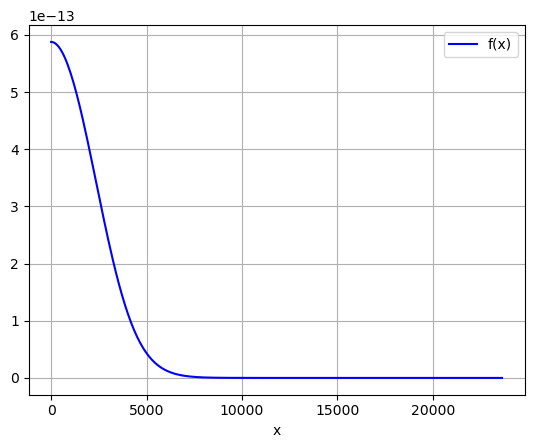

In [2]:
allThings = outputProfile(massInCU, aInCU, totalMassInCU)
#Hot Fix
x = allThings["x"][1::2]
psi = allThings["profile"][1::2]

In [3]:
def lengthCodeUnitToSI(cu):
    return cu/6.77193e-6/100.0

def lengthSIToPlanckUnit(SI):
    return SI/1.616255e-35

def densityCodeUnitToSI(cu):
    return cu*1000.0/1.619e-18

def densitySIToPlanckUnit(SI):
    return SI/5.155e96

def massCodeUnitToSI(cu):
    return cu/5.02788e-34/1000

def massSIToPlanckUnit(SI):
    return SI/2.176434e-8

def timeCodeUnitToSI(cu):
    return cu/2.03017e5

def timeSIToPlanckUnit(SI):
    return SI/5.391247e-44

In [4]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m

In [5]:
HBAR = 1.0
G = 1.0
c = 1.0

In [6]:
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 1.2233182200635002e+41
Omega: 3.656129092998464e-44
Epsilon (Should be 1): 1.0000000000000002
Delta: 46.926491232498286
New G: 3.734291520805297


In [7]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
x = np.concatenate((np.flip(-x), x))

psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
psi = np.concatenate((np.flip(psi), psi))
normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
psi = psi/normalization
psi = psi.astype(complex)

for index, value in enumerate(psi):
    if(value<1e-8):
        psi[index] = 0
psi = psi.astype(complex)

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA

print(psi)
print(dt)

[0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
 0.00000000e+00+0.j 0.00000000e+00+0.j 7.00866236e-06+0.j
 7.90146342e-0

In [8]:
dx = x[1]-x[0]
T = np.zeros((size,size))
TSph = np.zeros((size,size))
V = np.zeros((size,size))
Q = np.zeros((size,size))
V2Grav = np.zeros((size,size))
I = np.identity(size)
I = I.astype(complex)

phi = -np.exp(-x*x)/1000.0
phi[0] = 0.0
phi[size-1] = 0.0

In [9]:
def setupT():
    global T, TSph
    for i in range(size):
        T[i][i] = -2.0
        if(i!=size-1):
            T[i][i+1] = 1.0
            TSph[i][i+1] = 1.0/2.0/x[i]
        if(i!=0):
            T[i][i-1] = 1.0
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph
    T = T.astype(complex)
    TSph = TSph.astype(complex)

def setupQ():
    global Q
    for i in range(size):
        if(np.absolute(psi[i]) >= 1e-8):
            Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

    Q = Q.astype(complex)

def setupV2Grav():
    global V2Grav, phi, psi

    phi[0] = 0.0
    phi[size-1] = 0.0

    VGrav = np.zeros((size,size))
    VGrav2 = np.zeros((size))
    for i in range(size):
        if(i!=size-1 and i!=0):
            VGrav[i][i+1] = 1.0/2.0 + 1.0/2.0*dx/x[i]
            VGrav[i][i-1] = 1.0/2.0 - 1.0/2.0*dx/x[i]
        if(np.absolute(psi[i]) >= 1e-8):
            VGrav2[i] = 2.0*np.pi*dx*dx*np.absolute(psi[i])*np.absolute(psi[i])*GM

    toler = 3e-8
    count = 0

    while(True):
        phiNew = np.dot(VGrav, phi) - VGrav2
        error = np.abs((phiNew-phi)/phi)
        phi = phiNew
        count = count + 1
        if(np.nanmax(error[error!=np.inf])<toler):
            print(count)
            break
        
    for i in range(size//2):
        if(np.absolute(psi[i]) >= 1e-8):
            V2Grav[i][i] = phi[size-i-1]
            V2Grav[size-i-1][size-i-1] = phi[size-i-1]
        #Regulate
        phi[i] = phi[size-i-1]

    V2Grav.astype(complex)

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0/HBAR*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0/HBAR*(T+TSph+Q+V2Grav)
    #U1 = I + 1.0j*dt/2.0*(T+TSph+V2Grav)
    #U2 = I - 1.0j*dt/2.0*(T+TSph+V2Grav)

In [10]:
setupT()

0 0.0 0.11889693496678795


/tmp/ipykernel_68779/1042373627.py:45: RuntimeWarning: invalid value encountered in divide
  error = np.abs((phiNew-phi)/phi)


43272
1 0.01670205427581705 0.11889968633147342
120
2 0.0334041085516341 0.11890793453040212
280
3 0.05010616282745115 0.11892167413570606
382
4 0.0668082171032682 0.11894090864381905
460
5 0.08351027137908526 0.11896563568474335
524
6 0.1002123256549023 0.11899584326658845
578
7 0.11691437993071935 0.11903152514682996
628
8 0.1336164342065364 0.11907267896534027
674
9 0.15031848848235346 0.11911929189422141
718
10 0.16702054275817052 0.11917134788188817
40131
11 0.18372259703398755 0.11922607845053947
614
12 0.2004246513098046 0.119280695982021
688
13 0.21712670558562167 0.11933516470617561
711
14 0.2338287598614387 0.11938945372198154
726
15 0.25053081413725575 0.11944353991605094
736
16 0.2672328684130728 0.11949739308488173
744
17 0.28393492268888987 0.11955097791567224
750
18 0.3006369769647069 0.11960426806827926
755
19 0.317339031240524 0.11965723984708393
759
20 0.33404108551634104 0.11970986100703099
763
21 0.35074313979215804 0.11976210092233483
766
22 0.3674451940679751 0.11

/tmp/ipykernel_68779/1042373627.py:45: RuntimeWarning: divide by zero encountered in divide
  error = np.abs((phiNew-phi)/phi)


771
44 0.7348903881359502 0.12080543746653975
770
45 0.7515924424117673 0.12084214417561089
769
46 0.7682944966875843 0.1208780353129802
768
47 0.7849965509634014 0.12091310783836658
767
48 0.8016986052392184 0.12094735760252094
766
49 0.8184006595150355 0.12098077779580037
765
50 0.8351027137908525 0.12101336910672111
764
51 0.8518047680666696 0.12104513646004858
763
52 0.8685068223424867 0.12107607824031068
762
53 0.8852088766183037 0.12110619511365088
761
54 0.9019109308941208 0.12113550176058505
760
55 0.9186129851699378 0.12116401229032478
758
56 0.9353150394457548 0.12119171963084134
757
57 0.9520170937215718 0.1212185990157976
756
58 0.9687191479973889 0.12124462886132098
755
59 0.985421202273206 0.12126981746542614
753
60 1.002123256549023 0.12129422460208963
752
61 1.0188253108248402 0.12131794028110655
751
62 1.0355273651006571 0.12134101121050286
749
63 1.0522294193764743 0.12136338800038973
748
64 1.0689314736522912 0.12138496075014982
746
65 1.0856335279281082 0.1214056500

KeyboardInterrupt: 

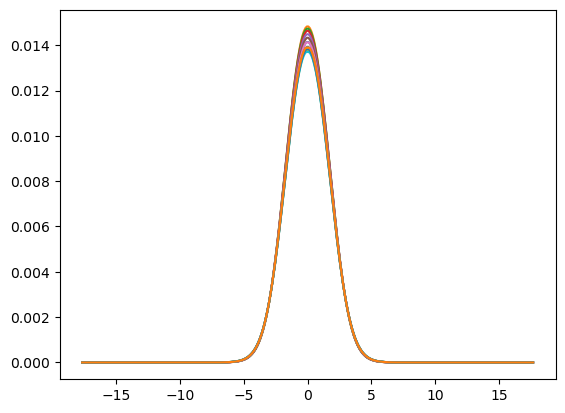

In [11]:
setupU1U2()
hello = []
ts = []
oldGM = GM
newGM = GM*1.5
for t in range(bigT):
    #Pertubation
    if(t==0):
        GM = newGM
    if(t==10):
        GM = oldGM


    print(t, t*dt, np.absolute(psi[size//2]))
    if(GM == oldGM):
        hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
        ts.append(t*dt)

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    #Regulate
    for i in range(size//2):
        psi[i] = psi[size-i-1]

    V2Grav.astype(complex)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

In [ ]:
plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

In [ ]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.2)
plt.ylim(0.0,0.5)
plt.xlabel("f (1/s)")